<a href="https://colab.research.google.com/github/YDayoub/Unet/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import yaml
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def show_tensor_images(image_tensor,size, num_images=25):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.0002
epochs = 50
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
initial_shape = 512
target_shape = 373

In [ ]:
!gdown --id 1Riifd0vbBNJQ0sI4rpsA-8yRJAlii59j --o /content/train-volume.tif
!gdown --id 1RVMkG-uzYcjoDSNPB8NvKJcTmuFjkVrz --o /content/train-labels.tif

Downloading...
From: https://drive.google.com/uc?id=1Riifd0vbBNJQ0sI4rpsA-8yRJAlii59j
To: /content/train-volume.tif
100% 7.87M/7.87M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RVMkG-uzYcjoDSNPB8NvKJcTmuFjkVrz
To: /content/train-labels.tif
100% 7.87M/7.87M [00:00<00:00, 123MB/s]


In [ ]:
  def crop(skip_con,new_shape):
    x_start = skip_con.shape[2]//2-round(new_shape[2]/2)
    x_end = x_start + new_shape[2]
    y_start = skip_con.shape[3]//2-round(new_shape[3]/2)
    y_end = y_start+new_shape[3]
    return skip_con[:,:,x_start:x_end,y_start:y_end]

In [ ]:
# load dataset
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

In [ ]:
class encoder_block(nn.Module):
  def __init__(self,input_features):
    super(encoder_block, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=input_features,out_channels=2*input_features,kernel_size=(3,3))
    self.conv2 = nn.Conv2d(in_channels=2*input_features,out_channels=2*input_features,kernel_size=(3,3))
    self.act = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self,inputs):
    x = self.act(self.conv1(inputs))
    x = self.act(self.conv2(x))
    x = self.pool(x)
    return x

In [ ]:
class decoder_block(nn.Module):
  def __init__(self,input_features):
    super(decoder_block, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
    self.conv1 = nn.Conv2d(in_channels = input_features,out_channels=input_features//2,kernel_size=(2,2))
    self.conv2 = nn.Conv2d(in_channels=input_features,out_channels=input_features//2,kernel_size=(3,3))
    self.conv3 = nn.Conv2d(in_channels=input_features//2,out_channels=input_features//2,kernel_size=(3,3))
    self.act = nn.ReLU()
  def forward(self,x,skip_con):
    x = self.upsample(x)
    x = self.act(self.conv1(x))
    cropped = crop(skip_con,x.shape)
    x = self.act(self.conv2(torch.cat([x,cropped],dim=1)))
    x = self.act(self.conv3(x))
    return x

In [ ]:
class UNET(nn.Module):
  def __init__(self,input_channels,n_classes,h_dims=64):
    super(UNET,self).__init__()
    self.up = nn.Conv2d(in_channels = input_channels,out_channels=h_dims,kernel_size=(1,1))
    for i in range(4):
      vars(self)['_modules']['enc_'+str(i)] = encoder_block(h_dims*(2**(i)))
    for i in range(4):
      vars(self)['_modules']['dec_'+str(i)] = decoder_block(h_dims*(2**(4-i)))
    self.down = nn.Conv2d(in_channels = h_dims,out_channels=n_classes,kernel_size=(1,1))
  def forward(self,x):
    x0 = self.up(x)
    layers = vars(self)['_modules']
    skip_cons = [x0]
    x = layers['enc_0'](x0)
    for i in range(1,4):
      skip_cons.append(x)
      x = layers['enc_'+str(i)](x)
    for i in range(4):
      x = layers['dec_'+str(i)](x,skip_cons.pop())
    x = self.down(x)
    return x

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0: Step 0: U-Net loss: 0.7205882668495178


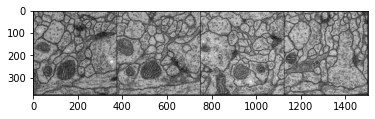

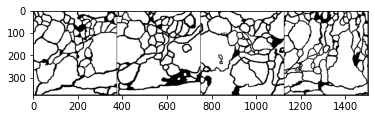

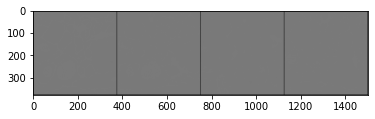

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2: Step 20: U-Net loss: 0.560130774974823


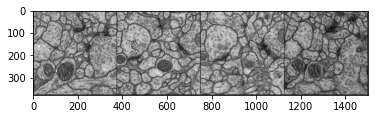

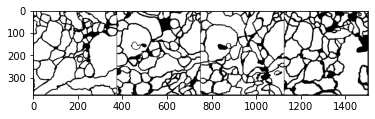

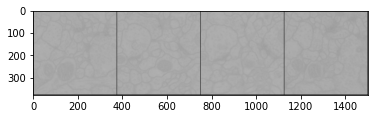

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5: Step 40: U-Net loss: 0.5026071071624756


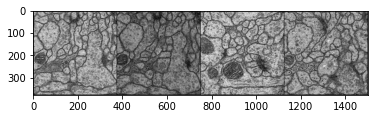

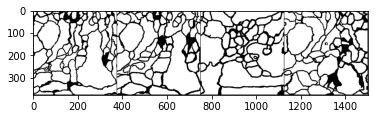

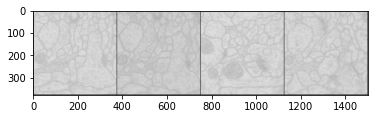

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7: Step 60: U-Net loss: 0.4431295692920685


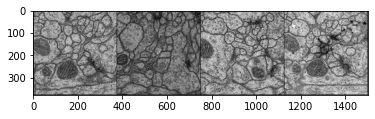

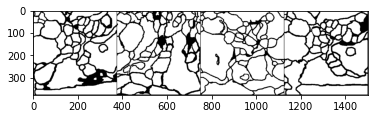

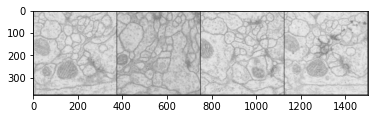

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10: Step 80: U-Net loss: 0.3877807557582855


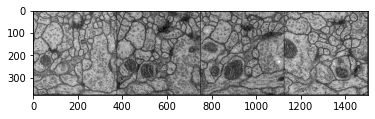

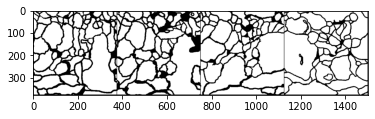

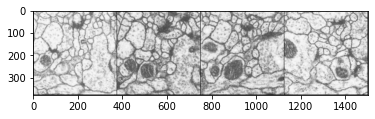

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12: Step 100: U-Net loss: 0.3696759343147278


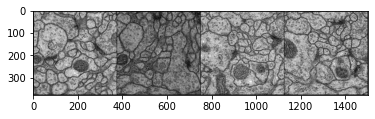

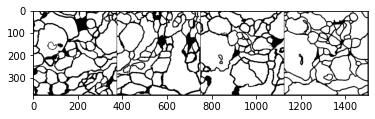

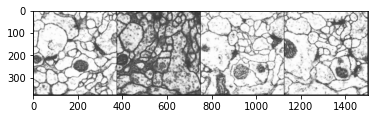

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15: Step 120: U-Net loss: 0.34491196274757385


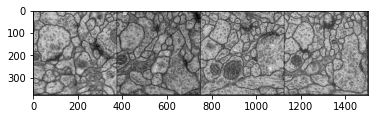

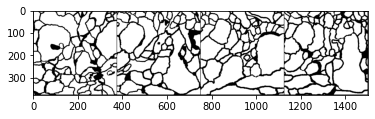

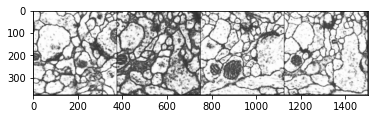

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17: Step 140: U-Net loss: 0.3434319794178009


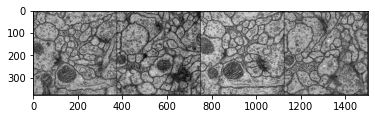

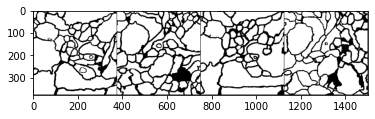

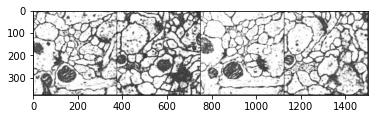

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20: Step 160: U-Net loss: 0.3124069273471832


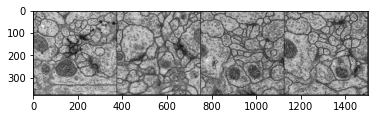

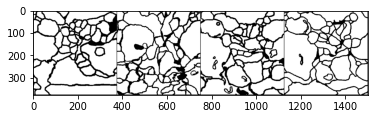

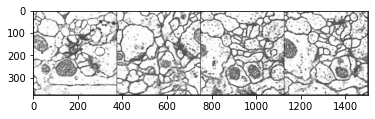

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22: Step 180: U-Net loss: 0.30918821692466736


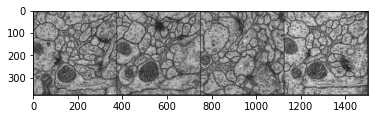

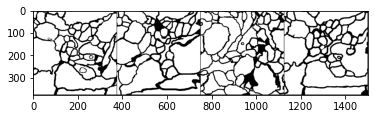

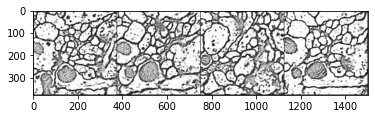

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25: Step 200: U-Net loss: 0.28698399662971497


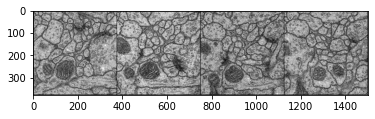

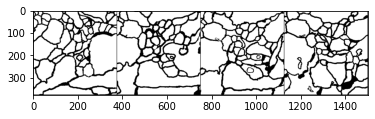

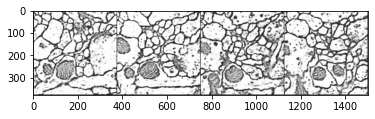

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27: Step 220: U-Net loss: 0.27589887380599976


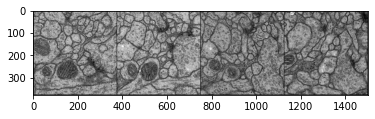

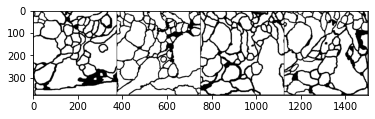

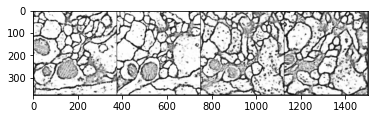

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30: Step 240: U-Net loss: 0.27525484561920166


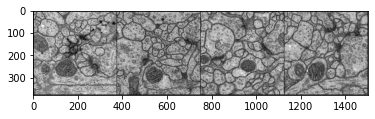

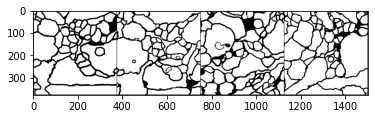

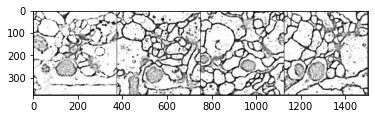

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32: Step 260: U-Net loss: 0.27070972323417664


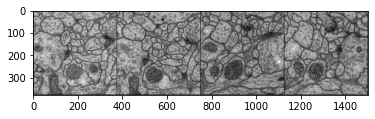

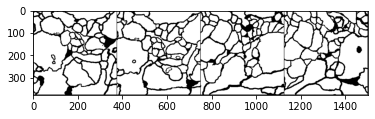

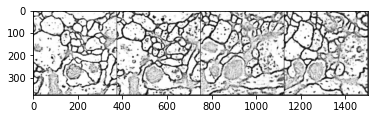

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35: Step 280: U-Net loss: 0.30133941769599915


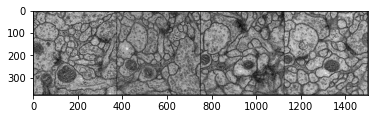

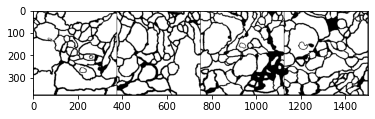

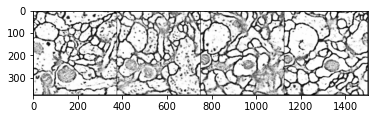

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37: Step 300: U-Net loss: 0.2603377103805542


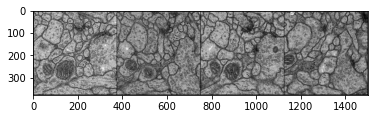

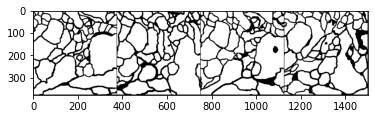

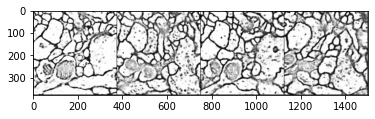

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40: Step 320: U-Net loss: 0.2315567433834076


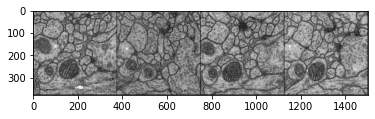

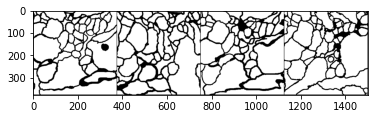

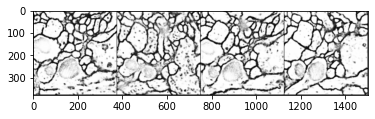

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42: Step 340: U-Net loss: 0.2764040231704712


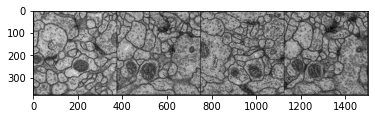

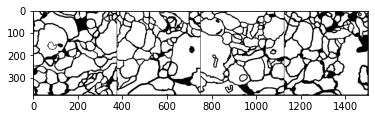

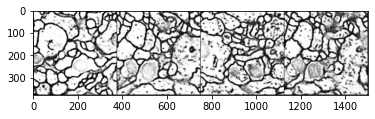

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45: Step 360: U-Net loss: 0.2806396782398224


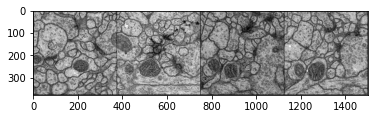

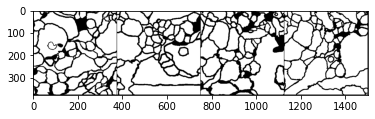

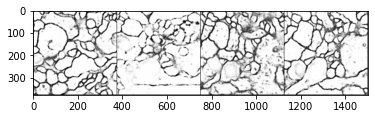

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47: Step 380: U-Net loss: 0.23436206579208374


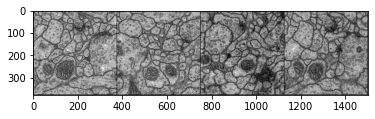

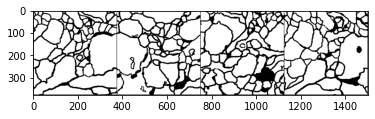

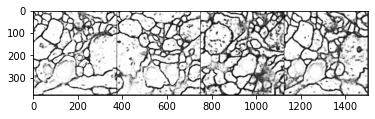

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
unet = UNET(input_dim, label_dim).to(device)
unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
cur_step = 0

for epoch in range(epochs):
    for real, labels in tqdm(dataloader):
        real = real.to(device)
        labels = labels.to(device)
        unet_opt.zero_grad()
        pred = unet(real)
        unet_loss = criterion(pred, labels)
        unet_loss.backward()
        unet_opt.step()

        if cur_step % display_step == 0:
            print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
            show_tensor_images(
                crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                size=(input_dim, target_shape, target_shape)
            )
            show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
            show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
        cur_step += 1